In [4]:
# Notebook: Expression Analysis
# Description: Notebook contains analysis of genes expresion for covid-19 and non-covid-19 patients
# Data collected from: GSE157103

In [5]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as sts
import seaborn as sns

from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from venn import venn
import numpy as np

from IPython.display import display
import scipy.stats as sts
import itertools

In [7]:
# Load EPIC manifest

In [8]:
epic = pd.read_csv(
    "../data/Additional/EPIC/MethylationEPIC_v-1-0_B4.csv",
    index_col=0,
    low_memory=False,
)

In [9]:
# Load genes containing DMPs in TSS [cov vs non-cov study]

dmg = pd.read_csv(
    "../Files/DMGenesCoVvsNoNCoVCorrected.csv", index_col=0
).UCSC_RefGene_Name
dmg = dmg.str.split(";").explode().to_frame()

# Add PARP9 (the same probes as DTX3L)
parp9_probes = dmg[dmg["UCSC_RefGene_Name"] == "DTX3L"]
parp9_probes["UCSC_RefGene_Name"] = "PARP9"
dmg = pd.concat((dmg, parp9_probes))

display(dmg)
genes_set = set(dmg.UCSC_RefGene_Name.unique())

print(f"DMPs: {len(set(dmg.index))}")
print(f"Genes: {dmg.UCSC_RefGene_Name.nunique()}")

<ipython-input-9-91b6142ad9d5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parp9_probes["UCSC_RefGene_Name"] = "PARP9"


,UCSC_RefGene_Name
CpG,
cg15528722,TTC33
cg24678928,DDX60
cg03607951,IFI44L
cg07815522,DTX3L
cg24103563,TRIM34
cg13304609,IFI44L
cg15452182,LOC101928650
cg17515347,AIM2
cg07863524,OR3A4


DMPs: 26
Genes: 20


In [10]:
# Load expression data

In [11]:
raw_ttable = pd.read_table("../Expression/GSE157103_genes.tpm.tsv", index_col=0).T
raw_ttable

#symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C1,0.49,0.00,0.21,0.04,0.07,0.0,0.03,18.92,4.07,0.0,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
C2,0.29,0.00,0.14,0.00,0.00,0.0,0.05,18.68,3.00,0.0,...,3.55,12.15,0.60,1.15,15.62,0.14,8.20,399.80,15.72,4.12
C3,0.26,0.00,0.03,0.02,0.00,0.0,0.07,13.85,1.83,0.0,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
C4,0.45,0.01,0.09,0.07,0.00,0.0,0.00,22.11,4.22,0.0,...,3.71,5.87,1.40,2.21,15.61,0.27,7.88,209.25,14.78,7.15
C5,0.17,0.00,0.00,0.05,0.07,0.0,0.00,8.45,1.17,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC22,0.30,0.00,0.02,0.02,0.00,0.0,0.00,17.06,1.96,0.0,...,0.26,1.01,0.13,0.46,5.93,0.24,1.58,447.14,3.04,1.00
NC23,0.70,0.00,0.02,0.01,0.00,0.0,0.00,20.31,1.54,0.0,...,0.64,0.83,0.18,0.73,8.75,0.12,1.57,748.55,4.55,1.56
NC24,0.75,0.00,0.27,0.00,0.06,0.0,0.00,27.25,3.42,0.0,...,1.18,2.14,0.41,1.29,14.93,0.14,5.05,437.62,10.34,3.99
NC25,2.80,0.00,0.04,0.00,0.00,0.0,0.00,21.64,1.43,0.0,...,0.42,0.61,0.19,0.45,4.77,0.33,1.07,369.66,1.83,0.96


In [12]:
# Drop genes with average expression value <= 0

raw_ttable = raw_ttable.loc[:, raw_ttable.mean().round(0) > 1]
raw_ttable.shape

(126, 10249)

In [13]:
# Select differential methylated genes

In [14]:
ttable = raw_ttable[genes_set.intersection(set(raw_ttable.columns))]

genes_set = set(ttable.columns)  # Update genes
print("Updated number of genes: ", len(genes_set))

# Add information about patient status
ttable["TYPE"] = [
    "COVID-19 USA" if name.startswith("C") else "non-COVID-19 USA"
    for name in raw_ttable.index
]  # Add TYPE column with disease status

ttable

Updated number of genes:  13


<ipython-input-14-6c8607d41f38>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttable["TYPE"] = [


#symbol,RSAD2,TTC33,PARP9,DDX60,TRA2B,MX1,TRIM34,IFI44L,PGBD3,CRNKL1,DTX3L,AIM2,TRIM22,TYPE
C1,812.32,6.41,402.93,115.76,33.01,968.53,52.94,470.26,1.40,19.21,145.23,102.60,878.28,COVID-19 USA
C2,28.71,5.82,112.39,15.15,40.79,53.01,24.57,10.81,1.60,15.67,39.90,36.29,236.38,COVID-19 USA
C3,797.39,3.44,431.47,105.36,16.20,861.15,34.64,355.75,1.85,18.24,122.19,157.94,802.34,COVID-19 USA
C4,20.48,6.32,100.88,13.57,49.26,101.72,29.81,17.33,2.43,21.55,40.19,16.85,224.91,COVID-19 USA
C5,168.49,5.72,398.58,43.04,26.13,59.63,35.90,44.53,1.63,19.54,95.64,279.70,1086.22,COVID-19 USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC22,1.38,1.06,13.07,1.07,17.96,11.96,5.28,1.19,0.74,6.00,7.99,5.84,24.43,non-COVID-19 USA
NC23,45.93,1.36,82.05,9.00,19.59,117.19,14.21,15.65,0.84,10.02,23.73,61.93,134.13,non-COVID-19 USA
NC24,7.30,3.78,62.55,5.33,40.09,48.53,19.71,4.96,2.60,14.85,24.23,15.15,86.22,non-COVID-19 USA
NC25,50.27,0.86,15.18,2.72,16.58,101.83,5.08,17.61,0.64,9.21,14.29,4.67,35.02,non-COVID-19 USA


In [15]:
# Perform Ward clustering on selected genes

<Figure size 936x936 with 0 Axes>

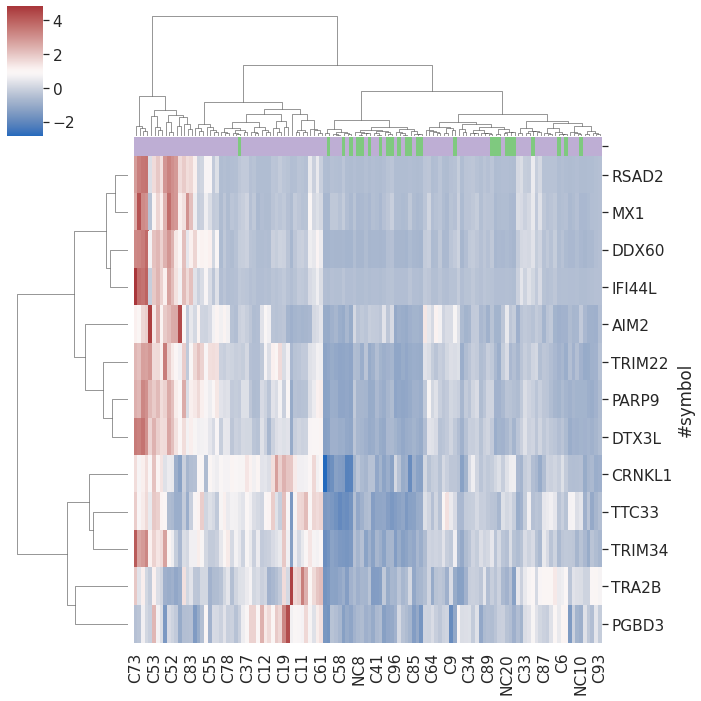

In [17]:
# Create palette for samples group
pal = sns.color_palette("Accent", ttable["TYPE"].nunique())
lut = dict(zip(map(str, ttable["TYPE"].unique()[::-1]), pal))
colors = ttable["TYPE"].map(lut)
colors.name = ""

# Set fig details
sns.set(font_scale=1.4)
plt.figure(figsize=(13, 13))

# Remove status from expression data
df_ttable = ttable.drop("TYPE", axis=1)

cols = df_ttable.columns
idx = df_ttable.index

# Scale expresion data
df_ttable = StandardScaler().fit_transform(df_ttable)
df_ttable = pd.DataFrame(df_ttable, index=idx, columns=cols).T

# Visualisation
fig = sns.clustermap(df_ttable, method="ward", col_colors=colors, cmap="vlag")
fig.savefig("../Plots/CLS_expression_with_PARP9.jpg")
plt.show()

In [18]:
# DEG - differential expressed genes

In [19]:
cf = pd.read_csv(
    "../data/processed/CF/USA_before_CFC.csv", index_col=0
)  # -> Estimated WBC fractions for each sample using RPC method from EpiDish package

sample_names = dict(
    pd.read_csv("../data/raw/CONCATED_USA_HB/SampleSheet.csv", index_col=0)["ID"]
)

cf.index = [
    sample_names.get(name) if name in sample_names.keys() else name for name in cf.index
]  # Convert GSE number to C if covid sample and NC in non covid samples

ins = set.intersection(
    set(ttable.index), set(cf.index)
)  # select overlapping samples for methylation data [predicted WBC fractions] and expression data

# Get overlapping samples
cf = cf.loc[ins]
ttable = ttable.loc[ins]

# Concate WBC fractions and status data
cf = pd.concat(
    (cf, ttable["TYPE"].map({"COVID-19 USA": 1, "non-COVID-19 USA": 0})), axis=1
).dropna()

display(cf)

cf.drop("Eosino", axis=1, inplace=True)  # Drop Eosino fraction due to low abudance

,B,NK,CD4T,CD8T,Mono,Neutro,Eosino,TYPE
C96,0.006014,0.007650,0.120617,0.032407,0.075474,0.757838,0.0,1
C3,0.000000,0.000000,0.000000,0.005660,0.054089,0.940251,0.0,1
C47,0.000000,0.000000,0.002740,0.000000,0.036391,0.960869,0.0,1
NC13,0.000000,0.000000,0.000000,0.013801,0.087422,0.898777,0.0,0
C44,0.007187,0.000000,0.000000,0.000000,0.080892,0.911921,0.0,1
...,...,...,...,...,...,...,...,...
C18,0.004785,0.028855,0.000000,0.030046,0.094977,0.841337,0.0,1
C91,0.000000,0.029584,0.154221,0.085335,0.058276,0.672584,0.0,1
C92,0.000000,0.000000,0.000000,0.000000,0.056790,0.943210,0.0,1
C65,0.004803,0.015502,0.000000,0.012942,0.064219,0.902535,0.0,1


In [19]:
# perform differential expression analysis

                            OLS Regression Results                            
Dep. Variable:                  RSAD2   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.552
Date:                Thu, 12 Aug 2021   Prob (F-statistic):             0.0233
Time:                        16:39:47   Log-Likelihood:                -836.16
No. Observations:                 125   AIC:                             1686.
Df Residuals:                     118   BIC:                             1706.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B          -1695.3429   1393.029     -1.217      0.2

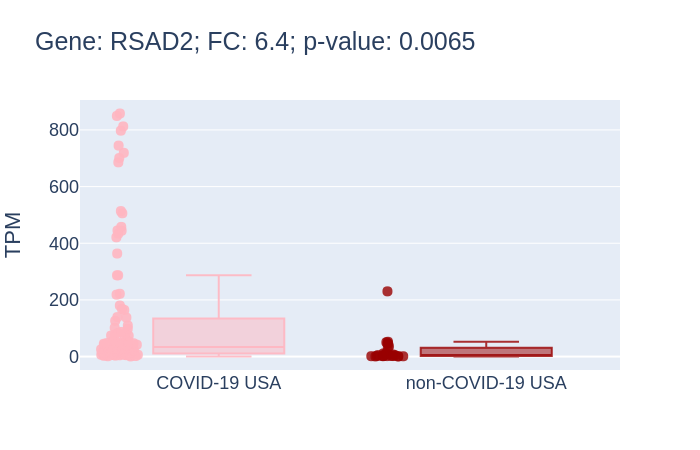

                            OLS Regression Results                            
Dep. Variable:                  TTC33   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.663
Date:                Thu, 12 Aug 2021   Prob (F-statistic):            0.00226
Time:                        16:39:52   Log-Likelihood:                -263.17
No. Observations:                 125   AIC:                             540.3
Df Residuals:                     118   BIC:                             560.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B             14.0966     14.229      0.991      0.3

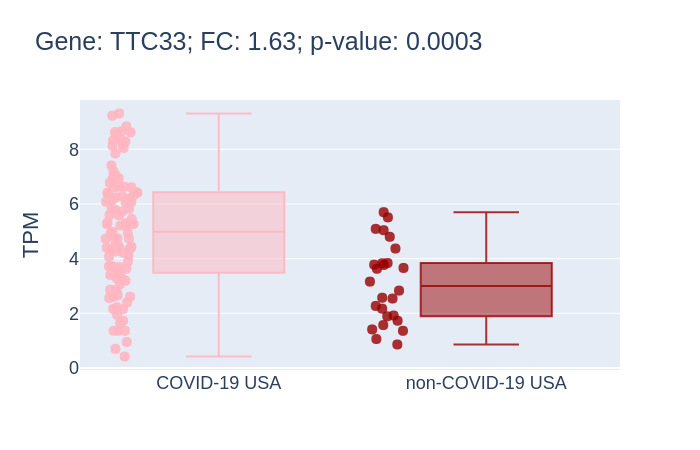

                            OLS Regression Results                            
Dep. Variable:                  PARP9   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     4.053
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           0.000991
Time:                        16:39:52   Log-Likelihood:                -756.93
No. Observations:                 125   AIC:                             1528.
Df Residuals:                     118   BIC:                             1548.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -862.6196    739.077     -1.167      0.2

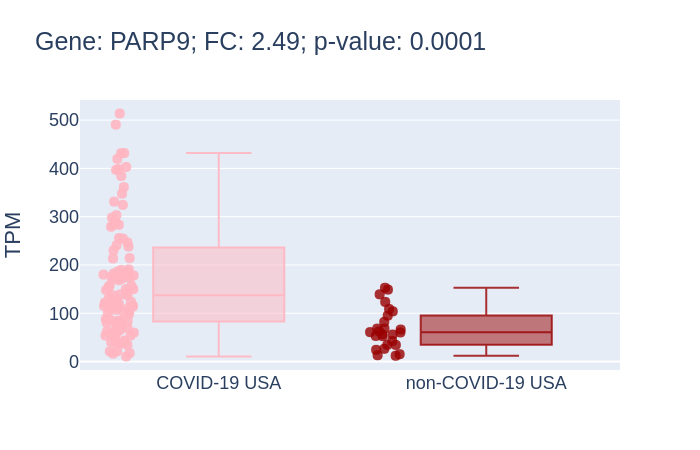

                            OLS Regression Results                            
Dep. Variable:                  DDX60   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.962
Date:                Thu, 12 Aug 2021   Prob (F-statistic):            0.00993
Time:                        16:39:52   Log-Likelihood:                -588.65
No. Observations:                 125   AIC:                             1191.
Df Residuals:                     118   BIC:                             1211.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -187.4442    192.308     -0.975      0.3

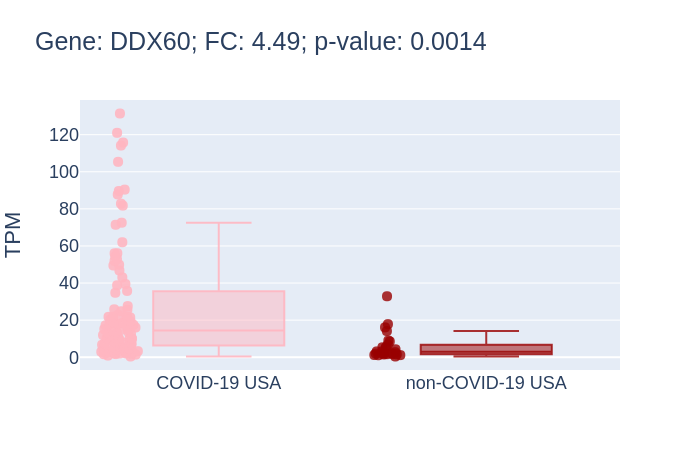

                            OLS Regression Results                            
Dep. Variable:                  TRA2B   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     10.25
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           4.08e-09
Time:                        16:39:52   Log-Likelihood:                -469.74
No. Observations:                 125   AIC:                             953.5
Df Residuals:                     118   BIC:                             973.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B            106.5093     74.283      1.434      0.1

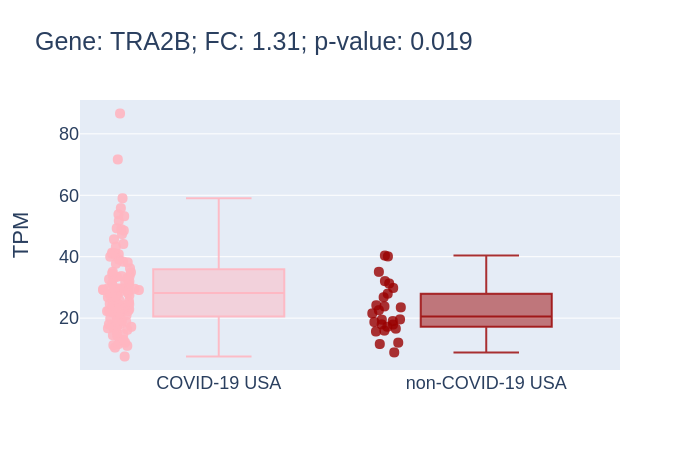

                            OLS Regression Results                            
Dep. Variable:                    MX1   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3.497
Date:                Thu, 12 Aug 2021   Prob (F-statistic):            0.00322
Time:                        16:39:52   Log-Likelihood:                -826.07
No. Observations:                 125   AIC:                             1666.
Df Residuals:                     118   BIC:                             1686.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B          -1261.3157   1284.983     -0.982      0.3

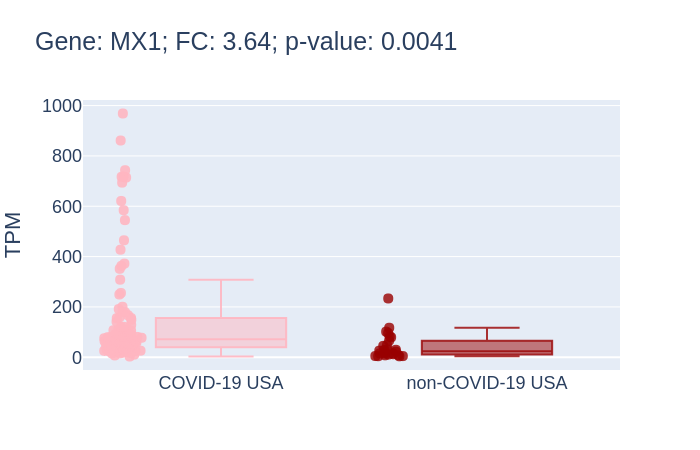

                            OLS Regression Results                            
Dep. Variable:                 TRIM34   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     3.894
Date:                Thu, 12 Aug 2021   Prob (F-statistic):            0.00139
Time:                        16:39:52   Log-Likelihood:                -471.80
No. Observations:                 125   AIC:                             957.6
Df Residuals:                     118   BIC:                             977.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B            -68.2032     75.512     -0.903      0.3

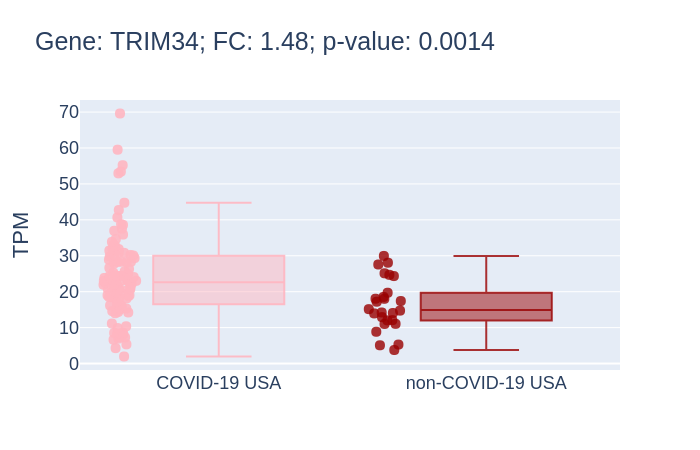

                            OLS Regression Results                            
Dep. Variable:                 IFI44L   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.862
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           0.000180
Time:                        16:39:52   Log-Likelihood:                -752.19
No. Observations:                 125   AIC:                             1518.
Df Residuals:                     118   BIC:                             1538.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -993.5239    711.558     -1.396      0.1

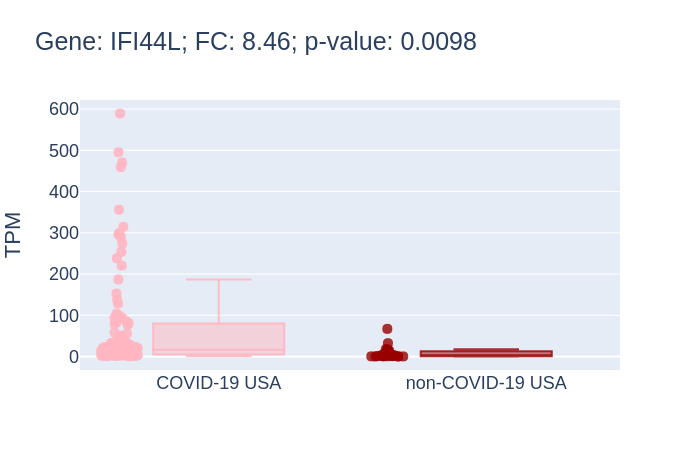

                            OLS Regression Results                            
Dep. Variable:                  PGBD3   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.647
Date:                Thu, 12 Aug 2021   Prob (F-statistic):             0.0191
Time:                        16:39:52   Log-Likelihood:                -143.50
No. Observations:                 125   AIC:                             301.0
Df Residuals:                     118   BIC:                             320.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B              1.0596      5.463      0.194      0.8

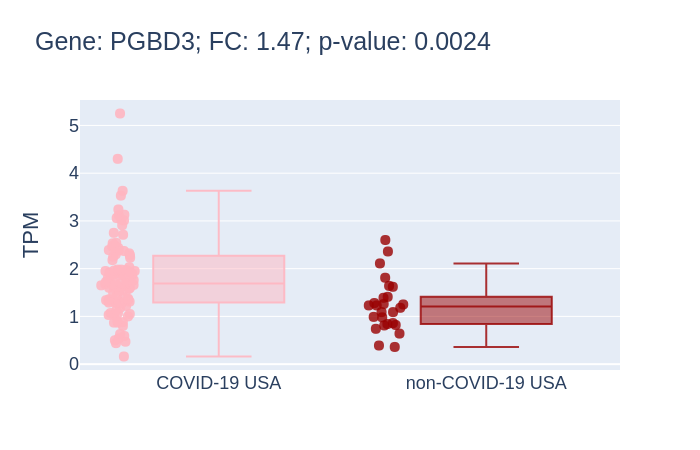

                            OLS Regression Results                            
Dep. Variable:                 CRNKL1   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.017
Date:                Thu, 12 Aug 2021   Prob (F-statistic):             0.0686
Time:                        16:39:52   Log-Likelihood:                -361.28
No. Observations:                 125   AIC:                             736.6
Df Residuals:                     118   BIC:                             756.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B            -13.6317     31.193     -0.437      0.6

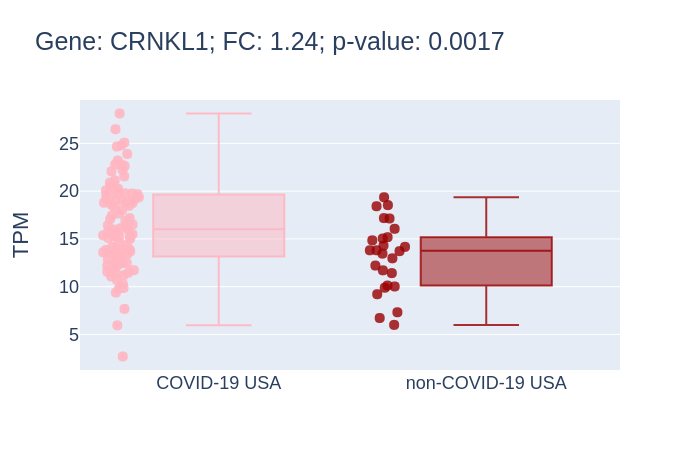

                            OLS Regression Results                            
Dep. Variable:                  DTX3L   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.069
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           0.000116
Time:                        16:39:52   Log-Likelihood:                -591.16
No. Observations:                 125   AIC:                             1196.
Df Residuals:                     118   BIC:                             1216.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -255.9974    196.219     -1.305      0.1

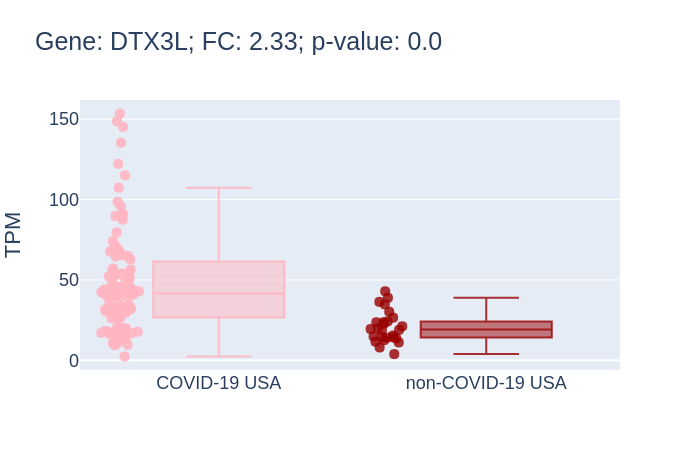

                            OLS Regression Results                            
Dep. Variable:                   AIM2   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     3.138
Date:                Thu, 12 Aug 2021   Prob (F-statistic):            0.00686
Time:                        16:39:52   Log-Likelihood:                -653.59
No. Observations:                 125   AIC:                             1321.
Df Residuals:                     118   BIC:                             1341.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -259.3629    323.323     -0.802      0.4

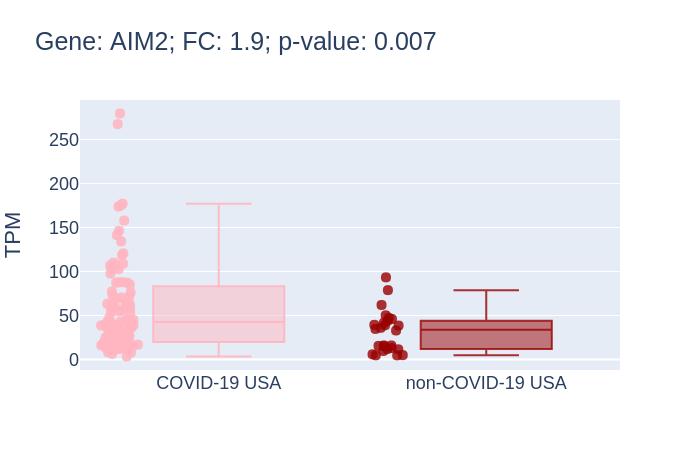

                            OLS Regression Results                            
Dep. Variable:                 TRIM22   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     3.799
Date:                Thu, 12 Aug 2021   Prob (F-statistic):            0.00170
Time:                        16:39:53   Log-Likelihood:                -862.78
No. Observations:                 125   AIC:                             1740.
Df Residuals:                     118   BIC:                             1759.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B          -1910.4366   1723.554     -1.108      0.2

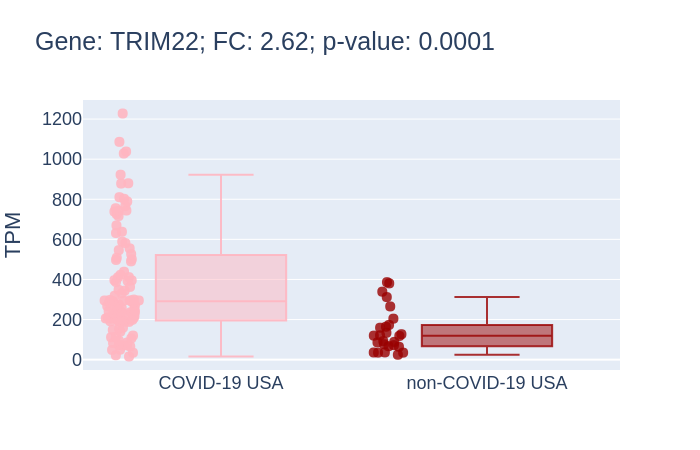

In [20]:
DEG = []

for common_gene in genes_set:

    df = pd.concat(
        (ttable[common_gene], cf), axis=1
    ).dropna()  # Merge expression data for specific gene with WBC fractions

    # Fit linear model: gene expression level ~ WBC fraction + disease type [covid / non-coivd]
    mod = sm.OLS(df[common_gene], df.drop(common_gene, axis=1))  # Initialize model
    res = mod.fit()

    # Get Wald pvalues
    pvalues = res.pvalues
    pval = round(pvalues.TYPE, 4)  # pvalue for disease TYPE variable

    # Get expression data for covid-19 samples
    cov = ttable[ttable["TYPE"] == "COVID-19 USA"][common_gene].values.flatten()

    # Get expression data for non-covid-19 samples
    nocov = ttable[ttable["TYPE"] == "non-COVID-19 USA"][common_gene].values.flatten()

    # Estimate Fold-change
    fc = round(np.mean(cov) / np.mean(nocov), 2)  # Fold change

    # If FC >= 1.5 or FC <= 0.5 and pval for disease TYPE variable in linear model <= 0.05 gene is DE
    if ((fc >= 1.5) | (fc <= 0.5)) & (pval <= 0.05):
        DEG.append(common_gene)

    # Show model summary
    print(res.summary())

    # Create Plots
    fig = go.Figure()

    # Add covid expression box
    fig.add_trace(
        go.Box(
            x=["COVID-19 USA"] * len(cov),
            y=cov,
            name="COVID-19",
            boxpoints="all",
            marker_color="rgba(255, 182, 193, .9)",
        )
    )

    # Add non-covid expression box
    fig.add_trace(
        go.Box(
            x=["non-COVID-19 USA"] * len(nocov),
            y=nocov,
            name="non-COVID-19 USA",
            boxpoints="all",
            marker_color="rgba(152, 0, 0, .8)",
        )
    )

    fig.update_layout(
        title=f"Gene: {common_gene}; FC: {fc}; p-value: {pval}",
        yaxis_title="TPM",
        showlegend=False,
    )

    fig.update_layout(legend=dict(font=dict(size=24), title=""), font=dict(size=18))
    fig.update_traces(marker=dict(size=10))

    fig.show(renderer="png")
    fig.write_image(f"../Plots/ExpressionBoxes/{common_gene}.jpg")

In [21]:
print(f"Number of DEGs: {len(DEG)}")
print(DEG)

pd.DataFrame(DEG).to_csv("../Files/CoVvsNoNCoVDEGs.csv")

Number of DEGs: 9
['PARP9', 'RSAD2', 'TTC33', 'IFI44L', 'DTX3L', 'TRIM22', 'MX1', 'AIM2', 'DDX60']


In [22]:
# Perform clustering using DEGs

<Figure size 936x936 with 0 Axes>

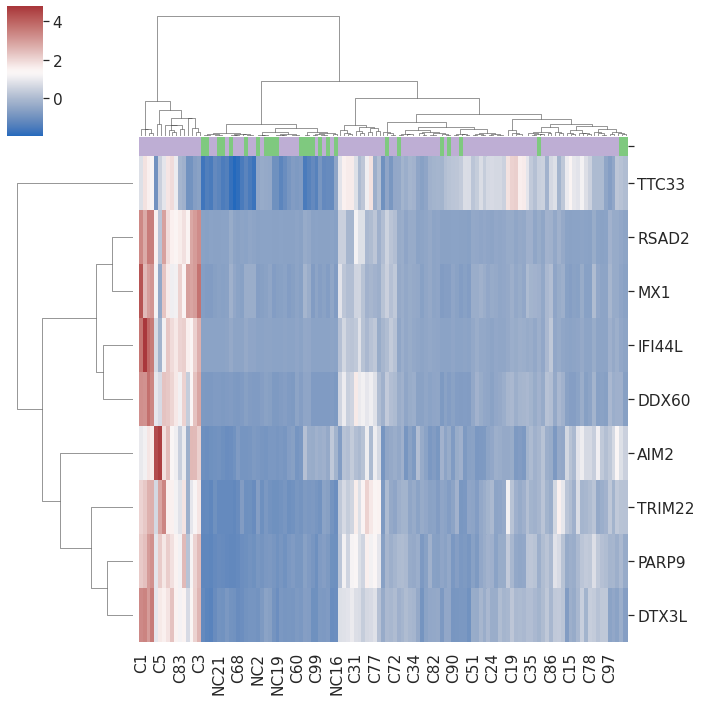

In [23]:
pal = sns.color_palette("Accent", ttable["TYPE"].nunique())
lut = dict(zip(map(str, ttable["TYPE"].unique()[::-1]), pal))
colors = ttable["TYPE"].map(lut)
colors.name = ""

plt.figure(figsize=(13, 13))
sns.set(font_scale=1.4)

df_ttable = StandardScaler().fit_transform(ttable[DEG]).T
df_ttable = pd.DataFrame(df_ttable, index=DEG, columns=ttable.index)

fig = sns.clustermap(df_ttable, method="ward", col_colors=colors, cmap="vlag")
fig.savefig("../Plots/CLS_DEGs_with_PARP9.jpg")
plt.show()

In [28]:
# Reconstruct dendrogram

In [29]:
df_ttable = df_ttable.T
df_ttable

,DTX3L,AIM2,TTC33,DDX60,TRIM22,MX1,RSAD2,PARP9,IFI44L
C41,-0.748516,-0.209259,-1.141013,-0.689544,-0.514441,-0.527272,-0.532229,-0.610522,-0.512581
C25,-0.273961,-0.233123,0.670647,-0.418362,-0.487126,-0.355570,-0.411970,-0.523249,-0.411000
C31,0.802413,0.108996,0.823159,1.712211,1.671778,0.593126,1.203447,1.329265,0.364776
C6,-0.353379,-0.792281,-0.087292,-0.421139,-0.679554,-0.472058,-0.470890,-0.589697,-0.464179
C51,-0.313670,-0.540475,0.268569,-0.375306,-0.496104,-0.277912,-0.382316,-0.568694,-0.393965
...,...,...,...,...,...,...,...,...,...
NC3,-0.971472,-0.297515,-1.136392,-0.708989,-0.760931,-0.663636,-0.549450,-0.837398,-0.522135
C11,-0.016829,-0.741056,1.705882,-0.064192,-0.197075,-0.415304,-0.378349,-0.401383,-0.248130
C74,-0.347520,0.120722,-0.461641,-0.536765,-0.521175,-0.375191,-0.506445,-0.241396,-0.446243
C82,-0.391135,-0.664115,-0.105779,-0.452390,-0.521670,-0.481200,-0.477662,-0.552634,-0.438491


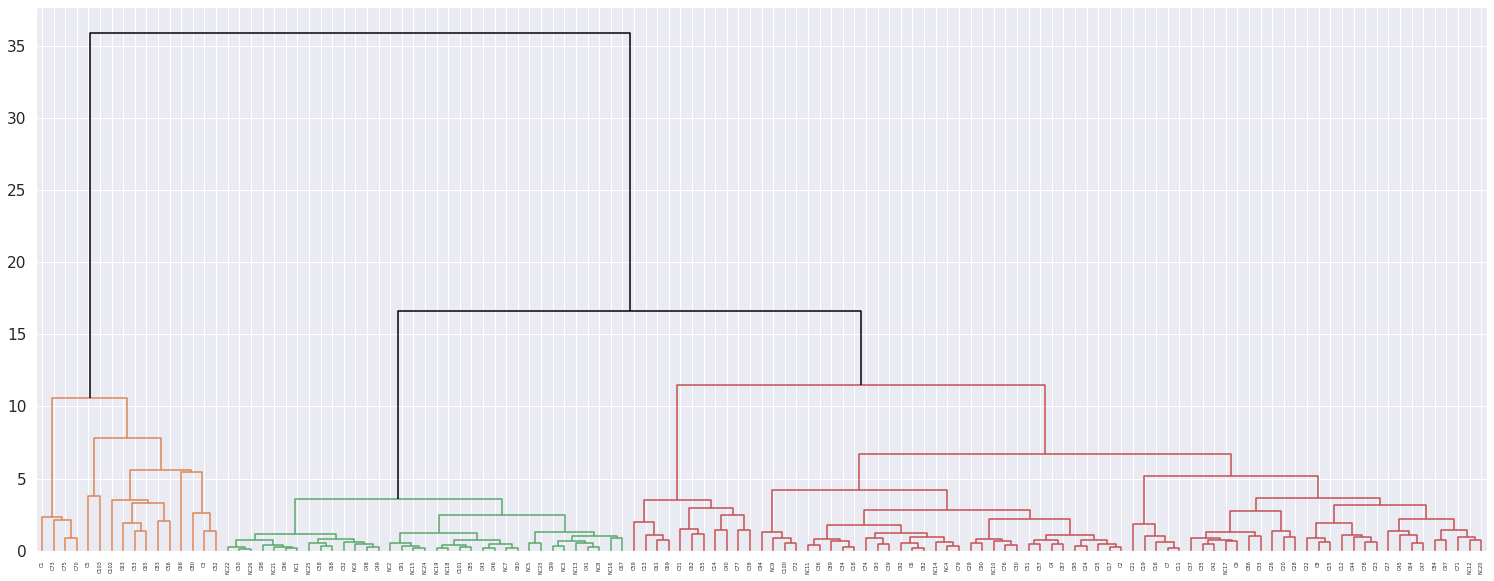

In [30]:
fig = plt.figure(figsize=(26, 10))

Z = linkage(df_ttable, "ward")
dn = dendrogram(
    Z,
    labels=df_ttable.index,
    color_threshold=12,
    above_threshold_color="00000",
    truncate_mode=None,
)

plt.show()
fig.savefig("../Plots/DendrogramCoVNonCoVUSA_with_PARP9.jpg")

In [31]:
# Annotate samples to clusters

In [32]:
cls_ = fcluster(Z, t=12, criterion="distance")
cls_ = pd.DataFrame(cls_, index=df_ttable.index, columns=["Cluster"])
cls_

,Cluster
C41,2
C25,3
C31,3
C6,3
C51,3
...,...
NC3,2
C11,3
C74,3
C82,3


In [33]:
# Load samples details from: https://doi.org/10.1186/s13148-021-01102-9

In [34]:
usa_poi = pd.read_csv("../data/raw/Annotations/Clinical_GSE174818.csv", index_col=0)
ins = set.intersection(set(usa_poi.index), set(cls_.index))
print(len(ins))

usa_poi = pd.concat((cls_.loc[ins], usa_poi.loc[ins]), axis=1)
usa_poi

125


,Cluster,Covid (1=yes),Diagnosis,ICU (1=yes),Sex,Age,Ethnicity,BMI,WHO ordinal at day 28,Charlson,...,Rheumatic disease,PUD,Liver disese,DM,Hemiplegia,Renal disease,Cancer (solid),HIV/AIDS,Leukemia/lymphoma,Smoking 1=y (current or former);0=never;?=unknown
Albany_sampleID,,,,,,,,,,,,,,,,,,,,,
C41,2,1,COVID-19,1,M,74,O,24.00,0,3,...,0,0,0,0,0,0,0,0,0,0
C25,3,1,COVID-19,1,M,55,O,34.60,0,2,...,0,0,0,0,0,0,0,0,0,?
C31,3,1,COVID-19,1,M,50,O,28.40,6,1,...,0,0,0,1,0,0,0,0,0,0
C6,3,1,COVID-19,0,M,45,H,24.39,0,1,...,0,0,0,0,0,0,0,0,0,?
C51,3,1,COVID-19,0,F,58,AA,34.01,0,6,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC3,2,0,pneumonia,1,M,65,W,54.60,7,7,...,0,0,0,1,0,1,0,0,0,1
C11,3,1,COVID-19,0,F,52,W,46.80,0,2,...,0,0,0,1,0,0,0,0,0,0
C74,3,1,COVID-19,1,F,55,W,32.05,0,2,...,0,0,0,1,0,0,0,0,0,0


In [35]:
# Test assocation between formed clusters and available data

In [36]:
for column in usa_poi.columns:
    if column == "Cluster":
        continue

    try:
        df = pd.crosstab(usa_poi["Cluster"], usa_poi[column])
        _, pval, dof, _ = sts.chi2_contingency(df)

        if pval <= 0.05 and dof <= 4:
            print(f"Column: {column}, p-value: {pval}")
            display(df)
            df["Sum"] = df.sum(axis=1)
            df.iloc[:, :2] = df.div(df["Sum"], axis=0)
            display(df.round(2))
            print("-" * 100)

    except Exception as e:
        print(f"Error: {e} for column: {column}")

Column: Covid (1=yes), p-value: 6.112472422864565e-07


Covid (1=yes),0,1
Cluster,,
1,0,16
2,18,17
3,8,66


Covid (1=yes),0,1,Sum
Cluster,,,
1,0.00,1.00,16
2,0.51,0.49,35
3,0.11,0.89,74


----------------------------------------------------------------------------------------------------
Column: ICU (1=yes), p-value: 0.0016916922608405764


ICU (1=yes),0,1
Cluster,,
1,14,2
2,12,23
3,34,40


ICU (1=yes),0,1,Sum
Cluster,,,
1,0.88,0.12,16
2,0.34,0.66,35
3,0.46,0.54,74


----------------------------------------------------------------------------------------------------
Column: Hydroxychloriquin, p-value: 0.0023058682160839394


Hydroxychloriquin,0,1
Cluster,,
1,2,14
2,19,16
3,19,55


Hydroxychloriquin,0,1,Sum
Cluster,,,
1,0.12,0.88,16
2,0.54,0.46,35
3,0.26,0.74,74


----------------------------------------------------------------------------------------------------
Column: Antibiotics, p-value: 0.0011195429242436541


Antibiotics,0,1
Cluster,,
1,2,14
2,9,26
3,2,72


Antibiotics,0,1,Sum
Cluster,,,
1,0.12,0.88,16
2,0.26,0.74,35
3,0.03,0.97,74


----------------------------------------------------------------------------------------------------
